# Real-time Audio Processing Testing Notebook

This notebook demonstrates and tests the audio processing system with faster-whisper integration.

In [6]:
!apt-get update && apt-get install -y portaudio19-dev python3-pyaudio

!brew install portaudio

# Install required packages
!pip install faster-whisper webrtcvad numpy websockets torch matplotlib sounddevice scipy pyaudio 

zsh:1: command not found: apt-get
To reinstall 19.7.0, run:
  brew reinstall portaudio


In [14]:
!pip install gtts pydub soundfile

  Using cached soundfile-0.12.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (14 kB)
Using cached soundfile-0.12.1-py2.py3-none-macosx_11_0_arm64.whl (1.1 MB)


In [3]:
import base64
import numpy as np
from collections import deque
from typing import Optional, List, Dict, Union, Tuple
import webrtcvad
import wave
import json
from gtts import gTTS
import torch
from faster_whisper import WhisperModel
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import asyncio
import websockets
import queue
import threading
import time
from gtts import gTTS
from pydub import AudioSegment
import io
import sounddevice as sd
import webrtcvad
from collections import deque
import logging
from datetime import datetime
import threading
import soundfile as sf

### Record human real audio

In [17]:
def record_audio(duration_seconds: float = 5.0, sample_rate: int = 16000, channels: int = 1) -> np.ndarray:
    """
    Record audio for the specified duration and return the audio data as a NumPy array.
    
    Args:
        duration_seconds: Duration of the audio recording in seconds.
        sample_rate: Sample rate of the audio recording in Hz.
        channels: Number of audio channels (1 for mono, 2 for stereo).
        
    Returns:
        Audio data as a NumPy array.
    """
    # Record audio
    print(f"Recording audio for {duration_seconds} seconds...")
    start_time = time.time()
    audio = sd.rec(int(duration_seconds * sample_rate), samplerate=sample_rate, channels=channels)
    
    while time.time() - start_time < duration_seconds:
        elapsed_time = time.time() - start_time
        progress = elapsed_time / duration_seconds * 100
        print(f"Recording progress: {progress:.2f}%", end="\r")
        time.sleep(0.1)
    
    print("Recording complete.")
    sd.wait()  # Wait for the recording to finish
    
    return audio

test_audio = record_audio(duration_seconds=30)

Recording audio for 30 seconds...
Recording complete. 99.80%


### Play the recorded audio sample

In [18]:
# Play the audio
sample_rate = 16000
sd.play(test_audio, sample_rate)

## Use saved audio

In [4]:
def read_from_file(file_path='test_audio.wav', sample_rate: int = 16000) -> np.ndarray:
    audio_data = None
    with wave.open(file_path, 'rb') as wf:
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != 'NONE':
            print("Audio file must be WAV format mono PCM.")
            return
        audio_data = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)
        audio_data = audio_data.astype(np.float32) / 32768.0
    return audio_data

test_audio = read_from_file()
                       

### 2. Test VAD (Voice Activity Detection)

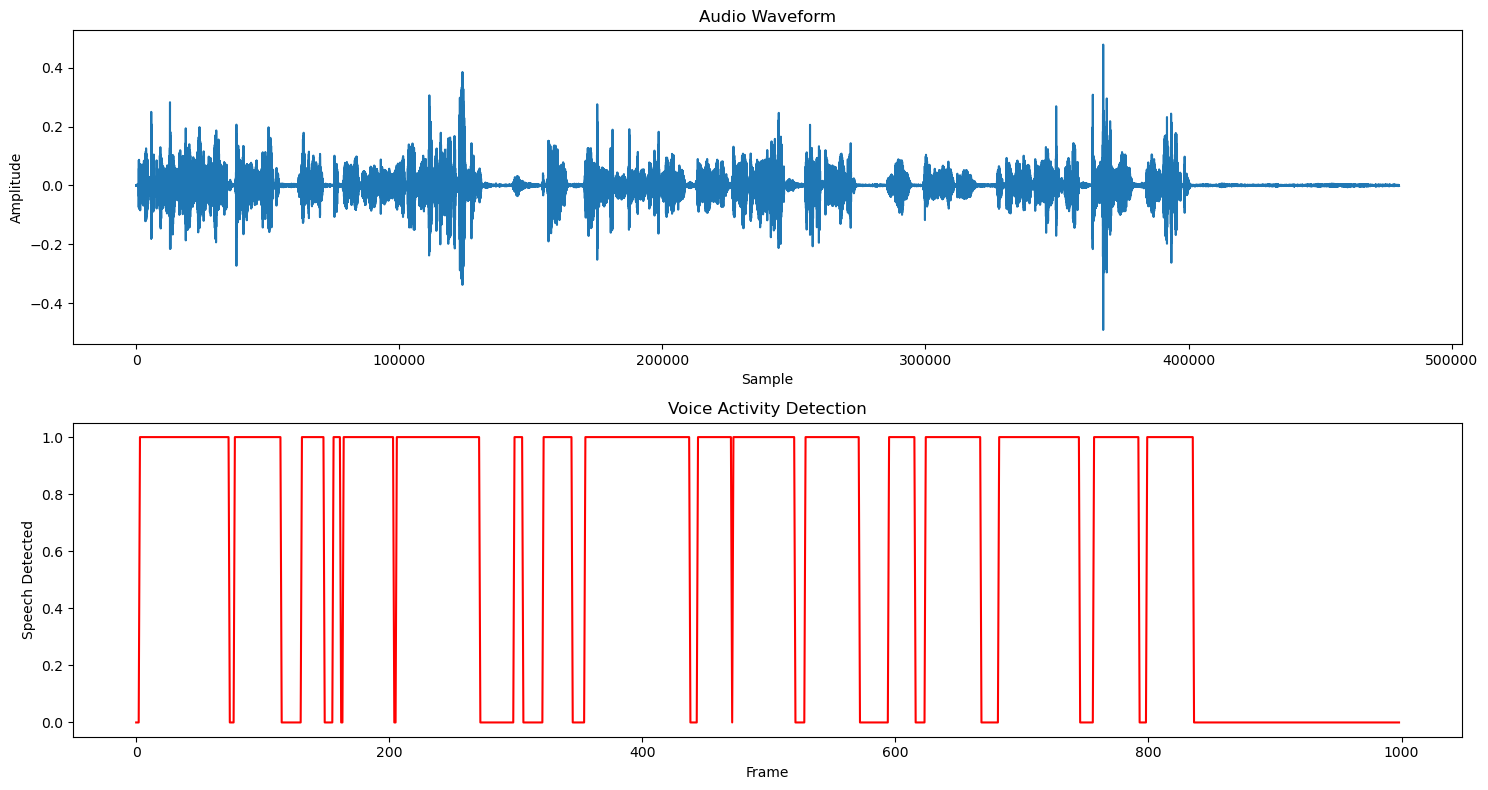

In [5]:
def test_vad(audio_data, sample_rate=16000, frame_duration=30):
    """
    Test Voice Activity Detection on audio data.
    """
    vad = webrtcvad.Vad(3)
    frame_length = int(sample_rate * (frame_duration / 1000.0))
    frames = []
    speech_frames = []

    for i in range(0, len(audio_data) - frame_length, frame_length):
        frame = audio_data[i:i + frame_length]
        frame_bytes = (frame * 32767).astype(np.int16).tobytes()
        frames.append(frame)
        speech_frames.append(vad.is_speech(frame_bytes, sample_rate))

    return frames, speech_frames

# Test VAD
frames, speech_frames = test_vad(test_audio)

# Visualize VAD results
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(speech_frames, 'r')
plt.title('Voice Activity Detection')
plt.xlabel('Frame')
plt.ylabel('Speech Detected')

plt.tight_layout()
plt.show()

In [19]:
def save_audio_to_file(audio_data: np.ndarray, filename: str, sample_rate: int = 16000) -> None:
    """
    Save audio data to a WAV file.
    
    Args:
        audio_data: Audio data as a NumPy array.
        filename: Name of the output WAV file.
        sample_rate: Sample rate of the audio data in Hz.
    """
    sf.write(filename, audio_data, sample_rate)

# Save the audio to a file
save_audio_to_file(test_audio, 'test_audio.wav')

### Detect VAD in human audio chunk wise

In [6]:
import os
import numpy as np
import webrtcvad
from typing import Tuple, List

# Explicitly set the TOKENIZERS_PARALLELISM environment variable
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

def detect_vad(audio: np.ndarray, sample_rate: int = 16000, 
               chunk_size_ms: int = 30, 
               vad_aggressiveness: int = 3,
               min_speech_duration_ms: int = 300,
               min_silence_duration_ms: int = 300) -> List[Tuple[int, int]]:
    """
    Detect voice activity in audio using the WebRTC VAD algorithm.
    
    Args:
        audio: numpy array of audio samples
        sample_rate: sampling rate in Hz
        chunk_size_ms: size of each chunk in milliseconds
        vad_aggressiveness: VAD aggressiveness mode (0-3, 3 being the most aggressive)
        min_speech_duration_ms: minimum duration of speech to consider it valid
        min_silence_duration_ms: minimum silence duration to split segments
        
    Returns:
        List of tuples containing start and end sample indices of voice activity
    """
    # Convert ms to samples
    chunk_size = int(sample_rate * chunk_size_ms / 1000)
    min_speech_samples = int(sample_rate * min_speech_duration_ms / 1000)
    min_silence_samples = int(sample_rate * min_silence_duration_ms / 1000)
    
    # Initialize WebRTC VAD
    vad = webrtcvad.Vad(mode=vad_aggressiveness)
    
    # Ensure audio is 16-bit signed integer
    if audio.dtype != np.int16:
        audio = (audio * 32767).astype(np.int16)
    
    # Process audio chunk by chunk
    is_speech = []
    for i in range(len(audio) // chunk_size):
        chunk = audio[i * chunk_size:(i + 1) * chunk_size]
        
        # Ensure the buffer size matches the expected chunk size
        if len(chunk) != chunk_size:
            # Pad the chunk with zeros to match the expected size
            chunk = np.pad(chunk, (0, chunk_size - len(chunk)), mode='constant')
        
        is_speech.append(vad.is_speech(chunk.tobytes(), sample_rate))
    
    # Convert boolean array to speech segments
    speech_segments = []
    in_speech = False
    start_idx = 0
    
    for i, speech in enumerate(is_speech):
        if speech and not in_speech:
            start_idx = i * chunk_size
            in_speech = True
        elif not speech and in_speech:
            # Check if speech duration is long enough
            if i * chunk_size - start_idx >= min_speech_samples:
                speech_segments.append((start_idx, i * chunk_size))
                in_speech = False
    
    # Handle the last segment
    if in_speech:
        speech_segments.append((start_idx, len(audio)))
    
    # Merge segments that are too close
    merged_segments = []
    if speech_segments:
        current_start, current_end = speech_segments[0]
        
        for start, end in speech_segments[1:]:
            if start - current_end < min_silence_samples:
                current_end = end
            else:
                merged_segments.append((current_start, current_end))
                current_start, current_end = start, end
        
        merged_segments.append((current_start, current_end))
    
    return merged_segments

def apply_vad_mask(audio: np.ndarray, vad_segments: List[Tuple[int, int]]) -> np.ndarray:
    """
    Apply VAD mask to audio, zeroing out non-speech segments.
    
    Args:
        audio: numpy array of audio samples
        vad_segments: list of (start, end) tuples for speech segments
        
    Returns:
        Masked audio array with non-speech segments set to zero
    """
    masked_audio = np.zeros_like(audio)
    
    for start, end in vad_segments:
        masked_audio[start:end] = audio[start:end]
    
    return masked_audio

In [7]:
sample_rate = 16000

vad_segments = detect_vad(test_audio, sample_rate)

print("Doing something")

# Print speech segments
for start, end in vad_segments:
    print(f"Speech found from {start/sample_rate:.2f}s to {end/sample_rate:.2f}s")


Doing something
Speech found from 0.09s to 3.45s
Speech found from 3.93s to 8.16s
Speech found from 8.97s to 9.27s
Speech found from 9.66s to 10.35s
Speech found from 10.65s to 17.16s
Speech found from 17.85s to 20.04s
Speech found from 20.46s to 22.38s
Speech found from 22.71s to 25.08s


### See if cuda is available

In [45]:
print("Is Cuda available {}".format(torch.cuda.is_available()))

Is Cuda available False


## 3. Test Faster Whisper Transcription

In [17]:
def test_transcription(audio_data, sample_rate=16000):
    """
    Test faster-whisper transcription.
    """
    # Initialize model
    model = WhisperModel(
        model_size_or_path='base',
        device="cuda" if torch.cuda.is_available() else "cpu",
        compute_type="float16" if torch.cuda.is_available() else "int8"
    )

    # Transcribe
    segments, info = model.transcribe(
        audio_data,
        beam_size=5
    )

    return [segment.text for segment in segments], info

# Test transcription
segments, info = test_transcription(test_audio)

print("Transcription Results:")
print(f"Detected language: {info.language} (probability: {info.language_probability:.2f})\n")
print(segments)



Transcription Results:
Detected language: en (probability: 0.99)

[" It's how technology can analyze emotions", ' just from the way we speak.', " Sometimes, it feels like we're living in a sci-fi movie", ' with all these advancements.', ' But then, there are times when you just want things', ' to be simple and not have to figure out the latest gadget.', ' It can be overwhelming.', ' And then, there are moments of calm', ' when everything falls into place.', " And you just know you're on the right track."]


## Sentiment analysis

In [18]:
from transformers import pipeline

sentiment_analysis = pipeline(
  "sentiment-analysis",
  framework="pt",
  model="SamLowe/roberta-base-go_emotions",
  device='mps'
)

def analyze_sentiment(text):
  results = sentiment_analysis(text)
  final_ = []
  for result in results:
    input_ = text[results.index(result)]
    final_.append({
        'input': input_,
        'label': result['label'],
        'score': result['score'],
        'with_sentiment': f"[{result['label']}]{input_}"
    })
  return final_

analyze_sentiment(segments)

[{'input': " It's how technology can analyze emotions",
  'label': 'neutral',
  'score': 0.7732527852058411,
  'with_sentiment': "[neutral] It's how technology can analyze emotions"},
 {'input': ' just from the way we speak.',
  'label': 'neutral',
  'score': 0.932525098323822,
  'with_sentiment': '[neutral] just from the way we speak.'},
 {'input': " Sometimes, it feels like we're living in a sci-fi movie",
  'label': 'neutral',
  'score': 0.4347034990787506,
  'with_sentiment': "[neutral] Sometimes, it feels like we're living in a sci-fi movie"},
 {'input': ' with all these advancements.',
  'label': 'neutral',
  'score': 0.8218415975570679,
  'with_sentiment': '[neutral] with all these advancements.'},
 {'input': ' But then, there are times when you just want things',
  'label': 'neutral',
  'score': 0.8201445937156677,
  'with_sentiment': '[neutral] But then, there are times when you just want things'},
 {'input': ' to be simple and not have to figure out the latest gadget.',
  'la

## Audio helper methods

In [43]:
class AudioFormatError(Exception):
    """Custom exception for audio format-related errors."""
    pass

def validate_audio_data(audio_data: np.ndarray) -> None:
    """
    Validate the input audio data array.

    Parameters:
    - audio_data: NumPy array of audio samples

    Raises:
    - TypeError: If input is not a NumPy array
    - ValueError: If array is empty or contains invalid values
    """
    if not isinstance(audio_data, np.ndarray):
        raise TypeError("Audio data must be a NumPy array")

    if audio_data.size == 0:
        raise ValueError("Audio data array is empty")

    if not np.issubdtype(audio_data.dtype, np.number):
        raise ValueError("Audio data must contain numeric values")

    if np.any(np.abs(audio_data) > 1.0):
        warnings.warn("Audio data contains values outside the normalized range [-1, 1]")

def get_supported_formats() -> list:
    """
    Return a list of supported audio formats.

    Returns:
    - List of supported format strings
    """
    return ['mp3', 'wav', 'ogg', 'flac']

def file_to_audio_data(
    audio_bytes: Union[io.BytesIO, bytes, str],
    format: Optional[str] = 'mp3',
    normalize: bool = True
) -> Tuple[np.ndarray, dict]:
    """
    Convert audio file data back to a NumPy array.

    Parameters:
    - audio_bytes: Either a BytesIO object, bytes object, or path to audio file
    - format: Audio format (optional, required if input is BytesIO or bytes)
    - normalize: Whether to normalize the output to [-1, 1] range (default: True)

    Returns:
    - Tuple containing:
        - NumPy array of audio samples
        - Dictionary with audio metadata (sample rate, channels, etc.)

    Raises:
    - ValueError: If input format is not specified for BytesIO/bytes input
    - AudioFormatError: If audio format is not supported
    """
    try:
        # Handle different input types
        if isinstance(audio_bytes, str):
            # Input is a file path
            audio_segment = AudioSegment.from_file(audio_bytes)
        elif isinstance(audio_bytes, (io.BytesIO, bytes)):
            # Input is bytes or BytesIO
            if format is None:
                raise ValueError("Format must be specified when input is bytes or BytesIO")
            if format.lower() not in get_supported_formats():
                raise AudioFormatError(f"Unsupported format: {format}")

            if isinstance(audio_bytes, bytes):
                audio_bytes = io.BytesIO(audio_bytes)

            audio_bytes.seek(0)
            audio_segment = AudioSegment.from_file(audio_bytes, format=format)
        else:
            raise TypeError("Input must be BytesIO, bytes, or file path")

        # Get audio info
        info = {
            'sample_rate': audio_segment.frame_rate,
            'channels': audio_segment.channels,
            'sample_width': audio_segment.sample_width,
            'duration_seconds': len(audio_segment) / 1000
        }

        # Convert to numpy array
        samples = np.array(audio_segment.get_array_of_samples())

        # Handle multi-channel audio
        if audio_segment.channels > 1:
            samples = samples.reshape((-1, audio_segment.channels))

        # Convert to float and normalize
        dtype_info = np.iinfo(samples.dtype)
        samples = samples.astype(np.float32)

        if normalize:
            samples /= max(abs(dtype_info.min), dtype_info.max)

        return samples

    except Exception as e:
        # Re-raise known exceptions, wrap unknown ones
        if isinstance(e, (AudioFormatError, ValueError, TypeError)):
            raise
        raise RuntimeError(f"Error decoding audio data: {str(e)}") from e

def _split_into_chunks(
    audio_data: np.ndarray,
    chunk_size: int
) -> List[np.ndarray]:
    """
    Split audio data into chunks with proper handling of remainder.

    Parameters:
    - audio_data: NumPy array of audio samples
    - chunk_size: Size of each chunk in samples

    Returns:
    - List of NumPy arrays, each representing a chunk of audio data
    """
    chunks = []
    for i in range(0, len(audio_data), chunk_size):
        chunk = audio_data[i:i + chunk_size]
        # Pad last chunk if necessary
        if len(chunk) < chunk_size:
            chunk = np.pad(
                chunk,
                (0, chunk_size - len(chunk)),
                mode='constant'
            )
        chunks.append(chunk)
    return chunks

## Audio Processor Class

In [44]:
class AudioProcessingError(Exception):
    """Custom exception for audio processing errors."""
    pass

class AudioProcessor:
    def __init__(
        self,
        sample_rate: int = 16000,
        chunk_duration_ms: int = 30,
        padding_duration_ms: int = 300,
        silence_threshold: float = 0.01,
        min_speech_duration_ms: int = 500,
        max_silence_duration_ms: int = 1000,
        model_size: str = "base",
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        compute_type: str = "float16" if torch.cuda.is_available() else "int8",
        max_buffer_size: int = 100,  # Maximum number of chunks to store
        logging_enabled: bool = True
    ):
        """
        Initialize AudioProcessor with enhanced configuration and error handling.
        """
        # Validate initialization parameters
        self._validate_init_params(
            sample_rate, chunk_duration_ms, padding_duration_ms,
            silence_threshold, min_speech_duration_ms, max_silence_duration_ms
        )

        self.sample_rate = sample_rate
        self.chunk_duration_ms = chunk_duration_ms
        self.padding_duration_ms = padding_duration_ms
        self.silence_threshold = silence_threshold
        self.min_speech_duration_ms = min_speech_duration_ms
        self.max_silence_duration_ms = max_silence_duration_ms
        self.max_buffer_size = max_buffer_size

        # Setup logging
        self.logger = self._setup_logging() if logging_enabled else None

        try:
            # Initialize VAD with error handling
            self.vad = webrtcvad.Vad(3)
            self._test_vad()

            # Initialize Whisper model with error handling
            self.model = self._initialize_whisper_model(model_size, device, compute_type)
        except Exception as e:
            raise AudioProcessingError(f"Failed to initialize audio processor: {str(e)}")

        # Enhanced buffer management
        self.audio_buffer = deque(maxlen=max_buffer_size)
        self.timestamp_buffer = deque(maxlen=max_buffer_size)  # Store timestamps
        self.current_transcript = ""
        self.silence_start = None
        self.is_speaking = False
        self.speaking_duration = 0
        self.partial_transcripts = []

        # State management
        self.last_process_time = None
        self.cumulative_silence = 0
        self.speech_segments: List[Tuple[float, float]] = []  # [(start_time, end_time)]

        # Threading lock to handle race conditions
        self.lock = threading.Lock()

    def _validate_init_params(self, *params):
        """Validate initialization parameters."""
        sample_rate, chunk_duration_ms, padding_duration_ms, \
        silence_threshold, min_speech_duration_ms, max_silence_duration_ms = params

        if sample_rate not in [8000, 16000, 32000, 48000]:
            raise ValueError(f"Invalid sample rate: {sample_rate}")
        if chunk_duration_ms < 10 or chunk_duration_ms > 500:
            raise ValueError(f"Invalid chunk duration: {chunk_duration_ms}")
        if silence_threshold < 0 or silence_threshold > 1:
            raise ValueError(f"Invalid silence threshold: {silence_threshold}")

    def _setup_logging(self) -> logging.Logger:
        """Setup logging configuration."""
        logger = logging.getLogger('AudioProcessor')
        logger.setLevel(logging.INFO)

        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)

        return logger

    def _test_vad(self):
        """Test VAD functionality with sample data."""
        test_audio = np.zeros(int(self.sample_rate * 0.03), dtype=np.int16)
        try:
            self.vad.is_speech(test_audio.tobytes(), self.sample_rate)
        except Exception as e:
            raise AudioProcessingError(f"VAD test failed: {str(e)}")

    def _initialize_whisper_model(
        self, model_size: str, device: str, compute_type: str
    ) -> WhisperModel:
        """Initialize and test Whisper model."""
        try:
            return WhisperModel(
                model_size_or_path=model_size,
                device=device,
                compute_type=compute_type,
                download_root=None  # Use default path
            )
        except Exception as e:
            raise AudioProcessingError(f"Failed to initialize Whisper model: {str(e)}")

    def _is_silence(self, audio_chunk: np.ndarray) -> bool:
        """
        Enhanced silence detection with multiple criteria.
        """
        if audio_chunk.size == 0:
            return True

        rms = np.sqrt(np.mean(np.square(audio_chunk)))
        peak = np.max(np.abs(audio_chunk))
        zero_crossings = np.sum(np.abs(np.diff(np.signbit(audio_chunk))))

        return (
            rms < self.silence_threshold and
            peak < self.silence_threshold * 2 and
            zero_crossings < len(audio_chunk) * 0.1
        )

    def process_audio_chunk(self, event_data: Dict) -> Optional[Dict]:
        """
        Process incoming audio chunk with enhanced error handling and monitoring.
        """
        try:
            current_time = datetime.now()

            # Input validation
            if not isinstance(event_data, dict) or "audio" not in event_data:
                raise ValueError("Invalid event data format")

            # Process audio data
            audio_data = file_to_audio_data(event_data["audio"])
            if audio_data.size == 0:
                return None

            with self.lock:
                # Store audio with timestamp
                self.audio_buffer.append(audio_data)
                self.timestamp_buffer.append(current_time)

                # Update processing time
                if self.last_process_time:
                    time_diff = (current_time - self.last_process_time).total_seconds() * 1000
                    if time_diff > self.chunk_duration_ms * 1.5:
                        self.logger.warning(f"Processing delay detected: {time_diff}ms")

                self.last_process_time = current_time

                # Enhanced voice activity detection
                is_speech = self._detect_voice_activity(audio_data)

                return self._update_speech_state(is_speech)

        except Exception as e:
            if self.logger:
                self.logger.error(f"Error processing audio chunk: {str(e)}")
            return None

    def _detect_voice_activity(self, audio_data: np.ndarray) -> bool:
        """
        Enhanced voice activity detection combining VAD and energy-based detection.
        """
        try:
            # VAD detection
            vad_result = self.vad.is_speech(
                audio_data.tobytes(),
                sample_rate=self.sample_rate
            )

            # Energy-based detection
            energy_result = not self._is_silence(audio_data)

            # Combine results (can be tuned based on requirements)
            return vad_result or energy_result

        except Exception as e:
            if self.logger:
                self.logger.warning(f"VAD detection failed, falling back to energy-based: {str(e)}")
            return not self._is_silence(audio_data)

    def _update_speech_state(self, is_speech: bool) -> Optional[Dict]:
        """
        Update speech state and handle transitions with improved logic.
        """
        if is_speech:
            if not self.is_speaking:
                self.is_speaking = True
                self.silence_start = None
                self.speaking_duration = 0
                if self.logger:
                    self.logger.debug("Speech started")

            self.speaking_duration += self.chunk_duration_ms
            self.cumulative_silence = 0

        else:  # Silence detected
            if self.is_speaking:
                if self.silence_start is None:
                    self.silence_start = datetime.now()
                    if self.logger:
                        self.logger.debug("Silence started")

                self.cumulative_silence += self.chunk_duration_ms

                # Check if silence duration exceeds threshold
                if self.cumulative_silence >= self.max_silence_duration_ms:
                    if self.speaking_duration >= self.min_speech_duration_ms:
                        return self._process_completed_utterance()
                    else:
                        self._reset_state()
                        if self.logger:
                            self.logger.debug("Speech duration too short, discarding")

        # Update partial transcripts periodically
        if len(self.audio_buffer) * self.chunk_duration_ms >= 500:
            self._update_partial_transcript()

        return None

    def _update_partial_transcript(self):
        """
        Update partial transcription with improved error handling and context.
        """
        if not self.audio_buffer:
            return

        try:
            audio = np.concatenate(list(self.audio_buffer))
            segments, _ = self.model.transcribe(
                audio,
                beam_size=5,
                word_timestamps=True,
                condition_on_previous_text=bool(self.partial_transcripts),
                initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None
            )

            transcript = " ".join(segment.text for segment in segments)
            if transcript.strip():
                self.partial_transcripts.append(transcript)
                if self.logger:
                    self.logger.debug(f"Partial transcript: {transcript}")

        except Exception as e:
            if self.logger:
                self.logger.error(f"Error updating partial transcript: {str(e)}")

    def _process_completed_utterance(self) -> Optional[Dict]:
        """
        Process completed utterance with enhanced error handling and analysis.
        """
        try:
            if not self.audio_buffer:
                return None

            # Combine audio chunks with proper handling of padding
            full_audio = np.concatenate(list(self.audio_buffer))

            # Add padding silence if needed
            if self.padding_duration_ms > 0:
                padding_samples = int(self.sample_rate * self.padding_duration_ms / 1000)
                full_audio = np.pad(full_audio, (padding_samples, padding_samples))

            # Transcribe with enhanced parameters
            segments, info = self.model.transcribe(
                full_audio,
                beam_size=5,
                word_timestamps=True,
                condition_on_previous_text=bool(self.partial_transcripts),
                initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None,
                vad_filter=True,
                vad_parameters=dict(
                    min_silence_duration_ms=self.max_silence_duration_ms / 2
                )
            )

            transcription = " ".join(segment.text for segment in segments)

            # Enhanced response decision
            should_respond = self._should_respond(transcription)

            if should_respond:
                response = {
                    "should_respond": True,
                    "transcript": transcription,
                    "language": info.language,
                    "language_probability": info.language_probability,
                    "speaking_duration_ms": self.speaking_duration,
                    "confidence": getattr(info, 'confidence', None),
                    "timestamp": datetime.now().isoformat()
                }
            else:
                response = None

            # Reset state
            self._reset_state()

            return response

        except Exception as e:
            if self.logger:
                self.logger.error(f"Error processing completed utterance: {str(e)}")
            self._reset_state()
            return None

    def _reset_state(self):
        """Reset all state variables."""
        with self.lock:
            self.audio_buffer.clear()
            self.timestamp_buffer.clear()
            self.is_speaking = False
            self.silence_start = None
            self.speaking_duration = 0
            self.cumulative_silence = 0
            self.partial_transcripts = []
            self.current_transcript = ""

    def _should_respond(self, transcript: str) -> bool:
        """
        Enhanced response detection with improved heuristics.
        """
        if not transcript.strip():
            return False

        transcript_lower = transcript.lower()

        # Question detection
        question_indicators = {
            "direct": ["?", "what", "how", "when", "where", "why", "who"],
            "indirect": ["can you", "could you", "would you", "will you"],
            "clarification": ["right", "correct", "isn't it", "don't you"]
        }

        # Command detection
        command_indicators = {
            "direct": ["please", "help", "tell me", "show me", "explain"],
            "action": ["do", "make", "create", "find", "search"],
            "system": ["start", "stop", "pause", "continue"]
        }

        # Check for questions
        for indicators in question_indicators.values():
            if any(indicator in transcript_lower for indicator in indicators):
                return True

        # Check for commands
        for indicators in command_indicators.values():
            if any(indicator in transcript_lower for indicator in indicators):
                return True

        # Check for complete thoughts
        sentence_endings = (".", "!", "?")
        if any(transcript.strip().endswith(end) for end in sentence_endings):
            return True

        # Check for meaningful content length
        words = transcript.split()
        if len(words) >= 5:  # Arbitrary threshold for meaningful content
            return True

        return False

## 4. Test Complete Pipeline

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm

class AudioProcessorTester:
    def __init__(self, save_results: bool = True, output_dir: str = "test_results"):
        """
        Initialize the tester with configuration options.

        Parameters:
        - save_results: Whether to save test results to files
        - output_dir: Directory to save test results
        """
        self.save_results = save_results
        self.output_dir = Path(output_dir)
        if save_results:
            self.output_dir.mkdir(exist_ok=True)

        self.test_metrics = {
            'total_chunks': 0,
            'processed_chunks': 0,
            'detected_utterances': 0,
            'processing_times': [],
            'chunk_sizes': [],
            'transcription_lengths': [],
            'language_probabilities': []
        }

    def test_complete_pipeline(
        self,
        audio_data: np.ndarray,
        chunk_size_ms: int = 30,
        sample_rate: int = 16000,
        processor_kwargs: Optional[Dict] = None
    ) -> Tuple[List[Dict], Dict]:
        """
        Test the complete audio processing pipeline with detailed metrics and validation.

        Parameters:
        - audio_data: Input audio data as numpy array
        - chunk_size_ms: Size of each chunk in milliseconds
        - sample_rate: Audio sample rate
        - processor_kwargs: Additional kwargs for AudioProcessor initialization

        Returns:
        - Tuple of (results, metrics)
        """
        try:
            # Initialize processor with custom parameters
            processor_kwargs = processor_kwargs or {}
            processor = AudioProcessor(
                sample_rate=sample_rate,
                chunk_duration_ms=chunk_size_ms,
                **processor_kwargs
            )

            # Validate input audio
            self._validate_audio_data(audio_data, sample_rate)

            # Split audio into chunks
            chunk_size = int(sample_rate * (chunk_size_ms / 1000.0))
            chunks = self._split_into_chunks(audio_data, chunk_size)

            # Process chunks with progress bar
            results = []
            timings = []

            with tqdm(total=len(chunks), desc="Processing audio chunks") as pbar:
                for i, chunk in enumerate(chunks):
                    # Time the processing
                    start_time = datetime.now()

                    # Create event data
                    event_data = self._create_event_data(chunk, i)

                    # Process chunk
                    result = processor.process_audio_chunk(event_data)

                    # Record timing
                    processing_time = (datetime.now() - start_time).total_seconds() * 1000
                    timings.append(processing_time)

                    # Update metrics
                    self._update_metrics(chunk, result, processing_time)

                    # Store result
                    if result:
                        results.append(self._enrich_result(result, i, processing_time))

                    pbar.update(1)

            # Calculate final metrics
            final_metrics = self._calculate_final_metrics()

            # Save results if enabled
            if self.save_results:
                self._save_test_results(results, final_metrics)
                self._generate_visualizations(results, timings)

            return results, final_metrics

        except Exception as e:
            raise RuntimeError(f"Pipeline test failed: {str(e)}")

    def _validate_audio_data(self, audio_data: np.ndarray, sample_rate: int):
        """Validate input audio data."""
        if not isinstance(audio_data, np.ndarray):
            raise ValueError("Audio data must be a NumPy array")

        if audio_data.size == 0:
            raise ValueError("Audio data is empty")

        expected_duration = len(audio_data) / sample_rate
        if expected_duration < 0.1:  # Arbitrary minimum duration
            raise ValueError(f"Audio too short: {expected_duration:.2f} seconds")

    def _split_into_chunks(
        self, audio_data: np.ndarray, chunk_size: int
    ) -> List[np.ndarray]:
        """Split audio data into chunks with proper handling of remainder."""
        chunks = []
        for i in range(0, len(audio_data), chunk_size):
            chunk = audio_data[i:i + chunk_size]
            # Pad last chunk if necessary
            if len(chunk) < chunk_size:
                chunk = np.pad(
                    chunk,
                    (0, chunk_size - len(chunk)),
                    mode='constant'
                )
            chunks.append(chunk)
        return chunks

    def _create_event_data(self, chunk: np.ndarray, index: int) -> Dict:
        """Create event data for chunk processing."""
        return {
            "event_id": f"event_{index}",
            "type": "input_audio_buffer.append",
            "timestamp": datetime.now().isoformat(),
            "audio": audio_data_to_file(chunk),
            "chunk_index": index
        }

    def _update_metrics(
        self,
        chunk: np.ndarray,
        result: Optional[Dict],
        processing_time: float
    ):
        """Update test metrics with chunk processing results."""
        self.test_metrics['total_chunks'] += 1
        self.test_metrics['processed_chunks'] += 1 if result else 0
        self.test_metrics['detected_utterances'] += 1 if result and result.get('should_respond') else 0
        self.test_metrics['processing_times'].append(processing_time)
        self.test_metrics['chunk_sizes'].append(len(chunk))

        if result:
            self.test_metrics['transcription_lengths'].append(
                len(result['transcript'].split())
            )
            self.test_metrics['language_probabilities'].append(
                result['language_probability']
            )

    def _enrich_result(self, result: Dict, chunk_index: int, processing_time: float) -> Dict:
        """Enrich result with additional metadata."""
        return {
            **result,
            "chunk_index": chunk_index,
            "processing_time_ms": processing_time,
            "timestamp": datetime.now().isoformat()
        }

    def _calculate_final_metrics(self) -> Dict:
        """Calculate final metrics from collected data."""
        processing_times = np.array(self.test_metrics['processing_times'])

        metrics = {
            "total_chunks_processed": self.test_metrics['total_chunks'],
            "utterances_detected": self.test_metrics['detected_utterances'],
            "detection_rate": self.test_metrics['detected_utterances'] / self.test_metrics['total_chunks'],
            "processing_time_stats": {
                "mean_ms": np.mean(processing_times),
                "std_ms": np.std(processing_times),
                "min_ms": np.min(processing_times),
                "max_ms": np.max(processing_times),
                "p95_ms": np.percentile(processing_times, 95)
            }
        }

        if self.test_metrics['transcription_lengths']:
            metrics["transcription_stats"] = {
                "mean_words": np.mean(self.test_metrics['transcription_lengths']),
                "max_words": np.max(self.test_metrics['transcription_lengths']),
                "total_words": sum(self.test_metrics['transcription_lengths'])
            }

        return metrics

    def _save_test_results(self, results: List[Dict], metrics: Dict):
        """Save test results and metrics to files."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save results
        results_file = self.output_dir / f"test_results_{timestamp}.json"
        with open(results_file, 'w') as f:
            json.dump({"results": results, "metrics": metrics}, f, indent=2)

        # Save metrics to CSV for easy analysis
        metrics_df = pd.DataFrame(results)
        metrics_file = self.output_dir / f"test_metrics_{timestamp}.csv"
        metrics_df.to_csv(metrics_file, index=False)

    def _generate_visualizations(self, results: List[Dict], timings: List[float]):
        """Generate visualizations of test results."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Processing times
        axes[0, 0].plot(timings)
        axes[0, 0].set_title('Processing Times per Chunk')
        axes[0, 0].set_xlabel('Chunk Index')
        axes[0, 0].set_ylabel('Processing Time (ms)')

        # Language probabilities
        if results:
            probs = [r['language_probability'] for r in results]
            axes[0, 1].hist(probs, bins=20)
            axes[0, 1].set_title('Language Detection Probabilities')
            axes[0, 1].set_xlabel('Probability')
            axes[0, 1].set_ylabel('Count')

        # Transcription lengths
        if results:
            lengths = [len(r['transcript'].split()) for r in results]
            axes[1, 0].hist(lengths, bins=20)
            axes[1, 0].set_title('Transcription Lengths')
            axes[1, 0].set_xlabel('Words')
            axes[1, 0].set_ylabel('Count')

        # Response timeline
        if results:
            chunk_indices = [r['chunk_index'] for r in results]
            responses = [1 if r['should_respond'] else 0 for r in results]
            axes[1, 1].scatter(chunk_indices, responses)
            axes[1, 1].set_title('Response Timeline')
            axes[1, 1].set_xlabel('Chunk Index')
            axes[1, 1].set_ylabel('Should Respond')

        plt.tight_layout()
        plot_file = self.output_dir / f"test_visualizations_{timestamp}.png"
        plt.savefig(plot_file)
        plt.close()

def test_pipeline(audio_data: np.ndarray, **kwargs):
    """
    Convenience function to test the pipeline with default settings.
    """
    tester = AudioProcessorTester()
    return tester.test_complete_pipeline(audio_data, **kwargs)

# Example usage
if __name__ == "__main__":
    # Run pipeline test
    results, metrics = test_pipeline(
        test_audio,
        chunk_size_ms=40
    )

    # Print results
    print("\nTest Results Summary:")
    print(f"Total chunks processed: {metrics['total_chunks_processed']}")
    print(f"Utterances detected: {metrics['utterances_detected']}")
    print(f"Detection rate: {metrics['detection_rate']:.2%}")
    print("\nProcessing Time Statistics:")
    for key, value in metrics['processing_time_stats'].items():
        print(f"{key}: {value:.2f}ms")

    # Individual results are available in the results list
    for result in results:
        print(f"\nTranscript: {result['transcript']}")
        print(f"Language: {result['language']} (prob: {result['language_probability']:.2f})")
        print(f"Processing time: {result['processing_time_ms']:.2f}ms")

Processing audio chunks:   0%|                                                              | 0/1216 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if p

KeyboardInterrupt: 

## LLM BASED DECISION WHETHER TO REPLY OR NOT?

In [41]:
import ollama  # Assuming the SDK is named 'ollama'

def is_reply_worthy(input_text: str, api_key: str) -> bool:
    """
    Determine if the input text is reply-worthy using Ollama's generate method.

    Parameters:
    - input_text: The input text to evaluate.
    - api_key: The API key for accessing Ollama's services.

    Returns:
    - bool: True if the input is reply-worthy, False otherwise.
    """
    # System prompt defining the task
    system_prompt = """
    Determine if the following input is worthy of a reply. Respond with 'Yes' if it is, and 'No' if it is not.
    Input:
    """

    # Combine the system prompt with the input text
    full_prompt = system_prompt + input_text

    try:
        # Generate the response
        response = ollama.generate(model='incept5/llama3.1-claude:latest', prompt=full_prompt)

        # Extract the generated text
        generated_text = response['response']

        # Determine if the input is reply-worthy
        if generated_text.lower() == 'yes':
            return True
        else:
            return False

    except Exception as e:
        print(f"Error generating response: {str(e)}")
        return False

# Example usage
input_text = "Hello, how are you?"
is_worthy = is_reply_worthy(input_text, api_key)
print(f"Is the input reply-worthy? {is_worthy}")

Is the input reply-worthy? False


## 5. Simulate WebSocket Connection

In [ ]:
async def simulate_websocket_stream(audio_data, chunk_size_ms=30):
    """
    Simulate streaming audio over WebSocket.
    """
    chunk_size = int(16000 * (chunk_size_ms / 1000.0))
    chunks = [audio_data[i:i + chunk_size] for i in range(0, len(audio_data), chunk_size)]

    session = AudioChatSession()

    class MockWebSocket:
        async def send(self, message):
            print(f"Received response: {message}")

    mock_ws = MockWebSocket()

    for i, chunk in enumerate(chunks):
        event_data = {
            "event_id": f"event_{i}",
            "type": "input_audio_buffer.append",
            "audio": encode_audio(chunk)
        }

        await session.handle_audio_message(mock_ws, event_data)
        await asyncio.sleep(chunk_size_ms / 1000.0)  # Simulate real-time

# Test WebSocket simulation
await simulate_websocket_stream(test_audio)

## 6. Performance Metrics

In [ ]:
def measure_performance(audio_data, num_runs=5):
    """
    Measure performance metrics of the system.
    """
    processor = AudioProcessor()

    timings = {
        'vad': [],
        'transcription': [],
        'total': []
    }

    for _ in range(num_runs):
        start_total = time.time()

        # Test VAD
        start = time.time()
        frames, speech_frames = test_vad(audio_data)
        timings['vad'].append(time.time() - start)

        # Test transcription
        start = time.time()
        segments, info = test_transcription(audio_data)
        timings['transcription'].append(time.time() - start)

        timings['total'].append(time.time() - start_total)

    print("Performance Metrics (averaged over {num_runs} runs):")
    for key, values in timings.items():
        avg_time = sum(values) / len(values)
        print(f"{key.capitalize()} processing time: {avg_time:.3f}s")

# Measure performance
measure_performance(test_audio)